# Test E & C Index calcs

In [1]:
import sys
sys.path.append('../')

#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.timePeriod as tp

In [16]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

# 1. Calculate CMIP Indeces

In [7]:
modelSet=_model.scenarioMip

In [8]:
modelSet

array([['CSIRO-ARCCSS', 'ACCESS-CM2', 'r1i1p1f1', 'r1i1p1f1'],
       ['CSIRO', 'ACCESS-ESM1-5', 'r1i1p1f1', 'r1i1p1f1'],
       ['AWI', 'AWI-CM-1-1-MR', 'r1i1p1f1', 'r1i1p1f1'],
       ['BCC', 'BCC-CSM2-MR', 'r1i1p1f1', 'r1i1p1f1'],
       ['CAMS', 'CAMS-CSM1-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['CAS', 'CAS-ESM2-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['NCAR', 'CESM2', 'r1i1p1f1', 'r10i1p1f1'],
       ['NCAR', 'CESM2-WACCM', 'r1i1p1f1', 'r1i1p1f1'],
       ['THU', 'CIESM', 'r1i1p1f1', 'r1i1p1f1'],
       ['CMCC', 'CMCC-CM2-SR5', 'r1i1p1f1', 'r1i1p1f1'],
       ['CMCC', 'CMCC-ESM2', 'r1i1p1f1', 'r1i1p1f1'],
       ['CNRM-CERFACS', 'CNRM-CM6-1', 'r1i1p1f2', 'r1i1p1f2'],
       ['CNRM-CERFACS', 'CNRM-ESM2-1', 'r1i1p1f2', 'r1i1p1f2'],
       ['CCCma', 'CanESM5', 'r1i1p1f1', 'r1i1p1f1'],
       ['CCCma', 'CanESM5-CanOE', 'r1i1p2f1', 'r1i1p2f1'],
       ['EC-Earth-Consortium', 'EC-Earth3', 'r1i1p1f1', 'r1i1p1f1'],
       ['EC-Earth-Consortium', 'EC-Earth3-CC', 'r1i1p1f1', 'r1i1p1f1'],
       ['

In [9]:
len(modelSet)

38

Climatology and piControl:

In [8]:
for iModel in [modelSet[29]]:
    
    print(iModel)
    
    try: 
            
        #to replicate Wang 2020
        tsXr = xarray.concat([fh.loadModelData(iModel[1], 'tos_Omon', 'historical', iModel[3], 
                                               chunks={'time':120}).tos, 
                              fh.loadModelData(iModel[1], 'tos_Omon', 'ssp585', iModel[3], 
                                               chunks={'time':120}).tos], 
                             dim='time')

        #tsXr = tsXr.where((tsXr.time.dt.year>=1900) * (tsXr.time.dt.year<2100), 
        #    drop=True)

        
    except Exception as e:
        print(iModel[1] + "Climatology did not calculate")
        print(e)
 

['MIROC' 'MIROC-ES2L' 'r1i1p1f2' 'r1i1p1f2']


In [9]:
tsXr

<xarray.DataArray 'tos' (time: 3012, y: 256, x: 360)>
dask.array<concatenate, shape=(3012, 256, 360), dtype=float32, chunksize=(120, 256, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
  * y        (y) float64 -88.0 -85.75 -85.25 -84.75 ... 146.8 148.6 150.5 152.4
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lat      (y, x) float32 -88.0 -88.0 -88.0 -88.0 ... 64.86 64.43 64.0 63.56
    lon      (y, x) float32 60.5 61.5 62.5 63.5 64.5 ... 59.94 59.96 59.98 59.99
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    original_name:  TO
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-07-10T00:47:14Z altered by CMOR: replaced missing va...

Cut it into the area of interest

In [10]:
tsXr=tsXr.where(
    (tsXr.lat>=-15) & (tsXr.lat<=15) &
    (tsXr.lon>=140) & (tsXr.lon<=280),
    drop=True
)

In [11]:
tsXr=tsXr.where(
    (tsXr.time.dt.year>=1900) * (tsXr.time.dt.year<2100), 
    drop=True
)


In [12]:
tsXr 

<xarray.DataArray 'tos' (time: 2400, y: 45, x: 140)>
dask.array<where, shape=(2400, 45, 140), dtype=float32, chunksize=(120, 45, 140), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
  * y        (y) float64 -14.9 -13.9 -12.91 -11.93 ... 11.4 12.36 13.34 14.33
  * x        (x) float64 80.5 81.5 82.5 83.5 84.5 ... 216.5 217.5 218.5 219.5
    lat      (y, x) float32 -14.9 -14.9 -14.9 -14.9 ... 14.33 14.33 14.33 14.33
    lon      (y, x) float32 140.5 141.5 142.5 143.5 ... 276.5 277.5 278.5 279.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    original_name:  TO
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-07-10T00:47:14Z altered by CMOR: replaced missing va...

In [13]:
from eofs.xarray import Eof



In [14]:
trendXr = tsXr.polyfit('time', 2)

In [15]:
trendXr

<xarray.Dataset>
Dimensions:               (degree: 3, x: 140, y: 45)
Coordinates:
  * degree                (degree) int64 2 1 0
  * y                     (y) float64 -14.9 -13.9 -12.91 ... 12.36 13.34 14.33
  * x                     (x) float64 80.5 81.5 82.5 83.5 ... 217.5 218.5 219.5
Data variables:
    polyfit_coefficients  (degree, y, x) float64 dask.array<chunksize=(3, 45, 140), meta=np.ndarray>

In [16]:
trendXr = xarray.polyval(tsXr.time, trendXr.polyfit_coefficients, 'degree')


In [17]:
detrendXr=tsXr-trendXr

In [18]:
detrendXr

<xarray.DataArray (time: 2400, y: 45, x: 140)>
dask.array<sub, shape=(2400, 45, 140), dtype=float64, chunksize=(120, 45, 140), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
  * y        (y) float64 -14.9 -13.9 -12.91 -11.93 ... 11.4 12.36 13.34 14.33
  * x        (x) float64 80.5 81.5 82.5 83.5 84.5 ... 216.5 217.5 218.5 219.5
    lat      (y, x) float32 -14.9 -14.9 -14.9 -14.9 ... 14.33 14.33 14.33 14.33
    lon      (y, x) float32 140.5 141.5 142.5 143.5 ... 276.5 277.5 278.5 279.5

In [19]:
sstMeanXr=detrendXr.where((detrendXr.time.dt.year>=1900) * (detrendXr.time.dt.year<2000), 
            drop=True).groupby('time.month').mean(dim='time')

In [20]:
sstMeanXr

<xarray.DataArray (month: 12, y: 45, x: 140)>
dask.array<stack, shape=(12, 45, 140), dtype=float64, chunksize=(1, 45, 140), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -14.9 -13.9 -12.91 -11.93 ... 11.4 12.36 13.34 14.33
  * x        (x) float64 80.5 81.5 82.5 83.5 84.5 ... 216.5 217.5 218.5 219.5
    lat      (y, x) float32 -14.9 -14.9 -14.9 -14.9 ... 14.33 14.33 14.33 14.33
    lon      (y, x) float32 140.5 141.5 142.5 143.5 ... 276.5 277.5 278.5 279.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [21]:
sstAnomXr=detrendXr.groupby('time.month')-sstMeanXr

In [22]:
#sstAnomXr=sstAnomXr.drop('month')


trendXr.isel(x=0,y=0).plot()

detrendXr.isel(x=0,y=0).plot()

sstAnomXr.isel(x=0,y=0).plot()

In [23]:
import cartopy.crs as ccrs


In [24]:
#there seems to be a bug in the Eof solver that doesn't handle dask very well,so pre calculating the result makes it work
sstAnomXr.load()

<xarray.DataArray (time: 2400, y: 45, x: 140)>
array([[[ 1.92334902e-01,             nan,             nan, ...,
         -1.30145968e-01, -1.07708649e-01, -1.33540662e-01],
        [ 1.83817824e-01,             nan,             nan, ...,
         -4.31438078e-02, -1.11394762e-01, -3.06342913e-01],
        [ 1.61061619e-01,             nan,             nan, ...,
         -1.05744212e-02, -2.43397312e-01, -6.91573940e-01],
        ...,
        [-2.27273126e-01, -2.04006120e-01, -1.79549975e-01, ...,
         -6.17830542e-01, -6.61542074e-01, -6.03417715e-01],
        [-2.39221419e-01, -2.45537895e-01, -2.27776449e-01, ...,
         -6.04444818e-01, -6.48862983e-01, -6.40631656e-01],
        [ 6.84872279e-02,  1.55394877e-02, -2.59988724e-02, ...,
         -5.78696594e-01, -6.00245433e-01, -5.19926032e-01]],

       [[ 2.77400501e-02,             nan,             nan, ...,
         -6.44718095e-02, -1.63340071e-01, -3.44365636e-01],
        [ 1.74491368e-01,             nan,             nan, ...,
         -1.05783804e-01, -2.36777665e-01, -5.31644456e-01],
        [ 2.72423355e-01,             nan,             nan, ...,
         -2.21087831e-01, -3.90200076e-01, -8.08911367e-01],
...
        [-4.43907716e-02, -2.88619835e-02, -1.75891321e-02, ...,
          1.70207401e-01,  1.61840056e-01,  1.91910158e-01],
        [-9.40375430e-02, -8.58856075e-02, -7.98263630e-02, ...,
          1.89287154e-01,  2.75361484e-01,  3.32669468e-01],
        [-1.39490912e-01, -1.34747877e-01, -1.32091799e-01, ...,
          1.34795229e-01,  3.70905168e-02, -1.75003324e-01]],

       [[-9.28682190e-03,             nan,             nan, ...,
         -9.02946747e-01, -1.13016559e+00, -8.30150541e-01],
        [-1.09643724e-01,             nan,             nan, ...,
         -9.15148267e-01, -7.21776119e-01, -3.12076211e-01],
        [-8.11235052e-02,             nan,             nan, ...,
         -7.11461237e-01, -3.64489498e-01, -5.68259195e-03],
        ...,
        [-1.88982538e-01, -1.89401457e-01, -2.04471418e-01, ...,
          1.35659278e-01,  2.54778702e-01,  3.61029349e-01],
        [-9.80835291e-02, -9.56087728e-02, -1.08157869e-01, ...,
          1.54369433e-01,  2.56896729e-01,  3.46017885e-01],
        [-1.00900588e-01, -9.81109576e-02, -1.10639741e-01, ...,
          6.61031904e-02, -1.01414673e-04, -6.01327222e-02]]])
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
  * y        (y) float64 -14.9 -13.9 -12.91 -11.93 ... 11.4 12.36 13.34 14.33
  * x        (x) float64 80.5 81.5 82.5 83.5 84.5 ... 216.5 217.5 218.5 219.5
    lat      (y, x) float32 -14.9 -14.9 -14.9 -14.9 ... 14.33 14.33 14.33 14.33
    lon      (y, x) float32 140.5 141.5 142.5 143.5 ... 276.5 277.5 278.5 279.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [25]:
def myFunc(xr):

    #although they don't really say this, I've applied an area weighting.

    weights = numpy.cos(numpy.deg2rad(xr.lat)
                    ).values[..., numpy.newaxis]

    solver=Eof(xr) #, weights=weights)

    #each described by a principal spatial pattern and an associated
    #principal component (PC) time series.

    pcXr = solver.pcs(pcscaling=1, npcs=2)
   
    return pcXr

In [26]:
#dcfAnomsXr=tp.averageForTimePeriod(sstAnomXr.rename('enso').to_dataset()).enso
#dcfAnomsXr=dcfAnomsXr.rename({'year':'time'})

In [27]:
#dcfAnomsXr=sstAnomXr.where(
#    (sstAnomXr.time.dt.month==12)+(sstAnomXr.time.dt.month==1)+(sstAnomXr.time.dt.month==2), drop=True)

In [28]:
pcTimeXr=myFunc(sstAnomXr)

In [29]:
pcTimeXr

<xarray.DataArray 'pcs' (time: 2400, mode: 2)>
array([[-1.2558873 ,  0.52164675],
       [-1.10859628,  0.47007031],
       [-0.78904269,  0.91319793],
       ...,
       [ 0.58775034, -1.86066162],
       [ 0.73832709, -2.00850353],
       [ 0.91793188, -0.8969594 ]])
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
  * mode     (mode) int64 0 1
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [31]:
def ensoPlotter(da, ax):
    cs=plt.contourf(da.lon, da.lat, da.values,  
                    transform=ccrs.PlateCarree(), 
                   center=True)

    gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    ax.coastlines(color='black')
    gl.top_labels=False
    #gl.left_labels=False

        #bottom legend
    cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)

In [32]:
pcTimeXr.std('time')

<xarray.DataArray 'pcs' (mode: 2)>
array([0.99979164, 0.99979164])
Coordinates:
  * mode     (mode) int64 0 1

In [33]:
pcTimeXr.mean('time')

<xarray.DataArray 'pcs' (mode: 2)>
array([2.07241631e-17, 1.39703064e-17])
Coordinates:
  * mode     (mode) int64 0 1

In [35]:
dcfTimeXr=pcTimeXr.where((pcTimeXr.time.dt.month==12)+(
    pcTimeXr.time.dt.month==1)+(pcTimeXr.time.dt.month==2), drop=True)

In [36]:
#pc1 = tp.averageForTimePeriod(pcTimeXr.sel(mode=0).rename('enso').to_dataset()).enso
#pc2 = tp.averageForTimePeriod(pcTimeXr.sel(mode=1).rename('enso').to_dataset()).enso

pc1 = dcfTimeXr.sel(mode=0)
pc2 = dcfTimeXr.sel(mode=1)

In [37]:
pc1

<xarray.DataArray 'pcs' (time: 600)>
array([-1.25588730e+00, -1.10859628e+00, -1.40341067e-01,  2.99694051e-02,
        1.97164718e-01,  2.03424227e+00,  1.94271259e+00,  1.64385675e+00,
       -9.89449866e-01, -1.12122581e+00, -9.34459459e-01, -8.32573797e-01,
       -8.54835189e-01, -6.00080684e-01, -8.52305805e-01, -8.18918164e-01,
       -6.47777665e-01, -5.30164730e-01, -5.07196686e-01, -1.00866464e-01,
       -5.76962298e-02,  8.82401102e-02, -4.35164816e-04,  6.76304250e-01,
        4.29061068e-01,  2.87344897e-01, -6.98876754e-01, -7.26715010e-01,
       -9.01346007e-01, -9.11247592e-01, -8.85512212e-01, -7.08612606e-01,
        4.54243735e-01,  3.69101698e-01,  4.33205115e-01,  2.12099298e+00,
        2.11608438e+00,  1.76933464e+00, -8.16062935e-01, -1.02835321e+00,
       -8.22686947e-01, -1.58223212e+00, -1.51016639e+00, -1.39610504e+00,
        1.34662463e-01,  2.06801760e-02,  1.58580255e-02,  1.43689120e+00,
        1.56697287e+00,  1.38659812e+00,  1.42752258e+00,  1.08978469e+00,
        7.59720890e-01, -1.29319206e+00, -1.14768512e+00, -9.72693370e-01,
       -1.13529512e+00, -1.14292787e+00, -1.00596502e+00,  4.75310559e-02,
        1.17586626e-02, -1.51055238e-02,  7.98930460e-01,  5.65653801e-01,
        4.07869754e-01,  1.86631279e+00,  1.50139212e+00,  1.16302345e+00,
       -1.21534940e+00, -1.08549390e+00, -9.75470842e-01, -1.06868358e+00,
       -1.04409852e+00, -5.59973293e-01, -5.38822962e-01, -3.17183065e-01,
       -1.60879609e-01, -1.86391423e-01, -4.23924772e-01, -1.85056842e-01,
...
       -3.24134808e-01,  1.38828384e+00,  1.48200405e+00,  1.28943968e+00,
        1.71070430e+00,  1.50248673e+00,  1.36278958e+00, -1.32223894e+00,
       -1.08569664e+00, -7.91945455e-01, -1.18900453e+00, -1.30407802e+00,
       -1.30645333e+00, -5.44440259e-01, -3.00515277e-01, -8.25849944e-02,
        1.62286705e+00,  1.67674962e+00,  1.62497430e+00,  6.39344304e-01,
        3.06820345e-01,  1.66076662e-01, -1.21714768e+00, -6.75852146e-01,
       -6.51999332e-01, -1.13465451e+00, -7.28650845e-01, -4.06268368e-01,
        9.55531983e-01,  9.70908894e-01,  1.02068522e+00,  1.99412077e+00,
        1.79518586e+00,  1.40323801e+00, -9.34360912e-01, -4.61356092e-01,
       -9.10013889e-01, -1.67584874e+00, -1.37922277e+00, -5.39433484e-01,
       -1.24297902e+00, -7.51634871e-01, -1.97201115e-01,  1.49693902e+00,
        1.54680746e+00,  1.34347269e+00,  1.62776329e-01, -5.44758483e-02,
       -1.32770958e-01, -1.57148007e+00, -6.98682191e-01, -7.22500102e-01,
        3.08364050e-01,  4.19491428e-01,  4.80040875e-01,  2.00246672e+00,
        1.99564880e+00,  1.51794688e+00, -6.89822715e-01, -5.44907452e-01,
       -7.96816063e-01, -1.62612264e+00, -8.96314603e-01, -7.47399473e-01,
       -3.04105959e-01, -5.67725844e-02,  1.51045246e-01,  1.99751819e+00,
        1.79694964e+00,  1.72029738e+00,  8.43167115e-01,  6.92735761e-01,
        6.75006962e-01, -6.72045152e-01, -5.69766538e-01, -4.86218440e-01,
       -8.86621651e-01, -2.94840057e-01, -1.39043033e-01,  9.17931877e-01])
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
    mode     int64 0
    month    (time) int64 1 2 12 1 2 12 1 2 12 1 2 ... 2 12 1 2 12 1 2 12 1 2 12

In [38]:
import numpy.polynomial as poly

In [39]:
pFit = poly.Polynomial.fit(pc1, pc2, 2)



In [40]:
pFit

Polynomial([-0.61746576, -0.42670721,  3.07505513], domain=[-2.05032819,  2.50953435], window=[-1.,  1.])

In [41]:
pFit.convert()

Polynomial([-0.54330736, -0.45881255,  0.59157443], domain=[-1.,  1.], window=[-1.,  1.])

In [42]:
alpha = pFit.convert().coef[2]

In [43]:
alpha

0.5915744333554289

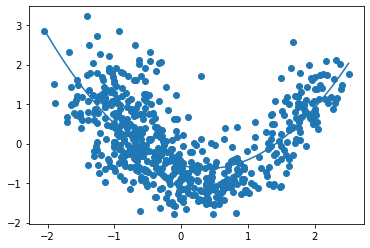

In [44]:
fig = plt.figure()

plt.scatter(pc1, pc2)

plt.plot(*pFit.linspace())

In [45]:
cXr=(pc1+pc2)/numpy.sqrt(2)
eXr=(pc1-pc2)/numpy.sqrt(2)

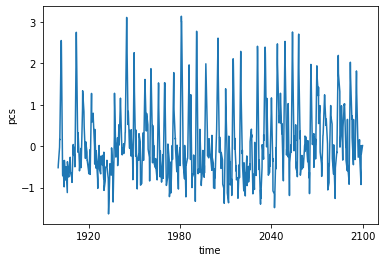

In [46]:
cXr.plot()

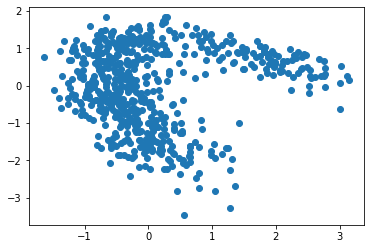

In [47]:
fig = plt.figure()

plt.scatter(cXr.values, eXr.values)

In [9]:
expectedToUse = modelSet[[4,9,11,12,15,17,30,29,22,31,32,33,21,6,7,35,36,20,8],:]
#expectedToUse = modelSet[[6,7],:]

In [10]:
expectedToUse

array([['CAMS', 'CAMS-CSM1-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['CMCC', 'CMCC-CM2-SR5', 'r1i1p1f1', 'r1i1p1f1'],
       ['CNRM-CERFACS', 'CNRM-CM6-1', 'r1i1p1f2', 'r1i1p1f2'],
       ['CNRM-CERFACS', 'CNRM-ESM2-1', 'r1i1p1f2', 'r1i1p1f2'],
       ['EC-Earth-Consortium', 'EC-Earth3', 'r1i1p1f1', 'r1i1p1f1'],
       ['EC-Earth-Consortium', 'EC-Earth3-Veg', 'r1i1p1f1', 'r1i1p1f1'],
       ['MIROC', 'MIROC6', 'r1i1p1f1', 'r1i1p1f1'],
       ['MIROC', 'MIROC-ES2L', 'r1i1p1f2', 'r1i1p1f2'],
       ['MOHC', 'HadGEM3-GC31-LL', 'r1i1p1f1', 'r1i1p1f3'],
       ['MPI-M', 'MPI-ESM1-2-HR', 'r1i1p1f1', 'r1i1p1f1'],
       ['MPI-M', 'MPI-ESM1-2-LR', 'r1i1p1f1', 'r1i1p1f1'],
       ['MRI', 'MRI-ESM2-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['NASA-GISS', 'GISS-E2-1-G', 'r1i1p1f2', 'r1i1p1f2'],
       ['NCAR', 'CESM2', 'r1i1p1f1', 'r10i1p1f1'],
       ['NCAR', 'CESM2-WACCM', 'r1i1p1f1', 'r1i1p1f1'],
       ['NCC', 'NorESM2-LM', 'r1i1p1f1', 'r1i1p1f1'],
       ['NCC', 'NorESM2-MM', 'r1i1p1f1', 'r1i1p1f1'],
  

In [11]:
len(expectedToUse)

19

In [ ]:
%run ../utils/ecIndex.ipynb

alphas=list()

for iModel in [expectedToUse[17]]:
    #try:
        print(iModel[1])
        
        tsXr = xarray.concat([fh.loadModelData(iModel[1], 'tos_Omon', 'historical', iModel[3], 
                                               chunks={'time':120}).tos, 
                              fh.loadModelData(iModel[1], 'tos_Omon', 'ssp585', iModel[3], 
                                               chunks={'time':120}).tos], 
                             dim='time')

        djfTsXr=tp.averageForTimePeriod(
            tsXr.to_dataset(name='enso')).rename({'year':'time'})

        indeces, pFit, eofsXr = ecIndex(tsXr)
        
        
        fig=plt.figure(figsize=(18,12))

        for mode in [0,1]:
            ax=fig.add_subplot(1,2,mode+1,
                           projection=ccrs.Miller(central_longitude=210))

            ensoPlotter(eofsXr.sel(mode=mode), ax)

            plt.title("mode " + str(mode))

        plt.show()

        #indecesDjf, pFit, eofsXr = ecIndex(djfTsXr)
        
        print(str(indeces.alpha.values)) #+ ' ... ' + str(indecesDjf.alpha.values))
        alphas.append(indeces.alpha.values)
        fig = plt.figure()

        plt.scatter(indeces.pc1, indeces.pc2)

        plt.plot(*pFit.linspace(), 'r')
        
        plt.show()
        
    #except Exception as e:
    #    print(e)

GFDL-ESM4


In [ ]:
wangsAnswers=[-0.2902,-0.4055,-0.1662, -0.1687, -0.2662, -0.2665, -0.3198, -0.3466, -0.1785, -0.2660, 
             -0.2338, -0.3387, -0.3644, -0.3216, -0.2436, -0.2505, -.2077, -.1931, -.01886]

In [ ]:
print(alphas)

In [ ]:
alphas[0]

In [ ]:
array=numpy.array(alphas)

In [ ]:
array-wangsAnswers